# Assignment 3: Policy Gradients (DDPG and REINFORCE)

Name: Chun-Han Yao

ID: A53234899

## Background
This exercise requires you to solve various continous control problems in OpenAI-Gym.  

DDPG is policy gradient actor critic method for continous control which is off policy. It tackles the curse of dimensionality / loss of performance faced when discretizing a continous action domain. DDPG uses similiar "tricks" as DQN to improve the stability of training, including a replay buffer and target networks.

Furthermore, you will implement REINFORCE for discrete and continous environments, and as a bonus compare the sample efficiency and performance with DQN and DDPG.


### DDPG paper: https://arxiv.org/pdf/1509.02971.pdf

### Environments:

#### InvertedPendulum-v2 environment:
<img src="inverted_pendulum.png" width="300">

#### Pendulum-v0 environment:
<img src="pendulum.png" width="300">

#### Halfcheetah-v2 environment:
<img src="half_cheetah.png" width="300">



### Setup environment for Actor Critic
- inline plotting
- gym
- directory for logging videos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

#environment
import gym

#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

logging_interval = 100
animate_interval = logging_interval * 5
logdir='./DDPG/test/'

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

### Set up gym environment
The code below does the following for you:
- Wrap environment, log videos, setup CUDA variables (if GPU is available)
- Record action and observation space dimensions
- Fix random seed for determinisitic training

In [3]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 2000
GAMMA = 0.99
BATCH_SIZE = 128

# Environments to be tested on
env_name = 'InvertedPendulum-v1'
# env_name = 'Pendulum-v0'
# env_name = 'HalfCheetah-v1' 

env = gym.make(env_name)

print('max_episode_steps =', env._max_episode_steps)
env._max_episode_steps = MAX_PATH_LENGTH

# wrap gym to save videos
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]
print('obs_dim =', obs_dim)
print('act_dim =', act_dim)

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")
    
# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

[2018-05-29 17:01:41,736] Making new env: InvertedPendulum-v1


max_episode_steps = 1000
obs_dim = 4
act_dim = 1


### Demonstrate your understanding of the simulation:
For the environments mentioned above ('Pendulum-v0', 'HalfCheetah-v2', 'InvertedPendulum-v2'),
- describe the reward system
- describe the each state variable (observation space)
- describe the action space
- when is the environment considered "solved"?

Ans: 

===== Pendulum-v0 =====
1. Reward system: -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2), range = [-16.27, 0] => small vertical angle, small rotational velocity, and small effort gets higher reward
   
2. Observation space: cos(theta) [-1, 1], sin(theta) [-1, 1], theta dot [-8, 8] (dim = 3)

3. Action space: joint effort [-2, 2] (dim = 1)

4. Termination: no termination

===== HalfCheetah-v1 =====
1. Reward system: (running velocity) - (sum of square of actions)

2. Observation space: the position, angle, velocity, angular velocity of the body parts (dim = 17)

3. Action space: the torque applied on different body parts (dim = 6)

4. Termination: no termination

===== InvertedPendulum-v2 =====
1. Reward system: 1 for every step taken

2. Observation space: the position and velocity of the cart and pole (dim = 4)

3. Action space: push cart towards left or right (dim = 1)

4. Termination: when the position of the tip of pole is out of [-0.2, 0.2]

### Implement an action normalization class:
To train across various environments, it is useful to normalize action inputs and outputs between [-1, 1]. This class should take in actions and implement forward and reverse functions to map actions between [-1, 1] and [action_space.low, action_space.high].

Using the following gym wrapper, implement this class.
- https://github.com/openai/gym/blob/78c416ef7bc829ce55b404b6604641ba0cf47d10/gym/core.py
- i.e. we are overriding the outputs scale of actions. 

In [4]:
class NormalizeAction(gym.ActionWrapper):
    def __init__(self, env=None):
        super(NormalizeAction, self).__init__(env)
        
    def _action(self, action):
        #tanh outputs (-1,1) from tanh, need to be [action_space.low, action_space.high]
        r = (self.action_space.high - self.action_space.low) / 2.
        mid = (self.action_space.high + self.action_space.low) / 2.
        return mid + r * action
    
    def _reverse_action(self, action):
        #reverse of that above
        r_inv = 2. / (self.action_space.high - self.action_space.low)
        mid = (self.action_space.high + self.action_space.low) / 2.
        return r_inv * (action - mid)

# DDPG

### Write a weight syncing function
In contrast to DQN, DDPG uses soft weight sychronization. At each time step following training, the actor and critic target network weights are updated to track the rollout networks. 
- target_network.weights <= target_network.weights \* (1 - tau) + source_network.weights \* (tau)

In [5]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

### Write a Replay class that includes all the functionality of a replay buffer
DDPG is an off policy actor-critic method and an identical replay buffer to that used for the previous assignment is applicable here as well (do not include the generate_minibatch method in your Replay class this time). Like before, your constructor for Replay should create an initial buffer of size 1000 when you instantiate it.

The replay buffer should kept to some maximum size (60000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). 

In [6]:
class Replay():       
    def __init__(self, max_size=60000, init_length=1000):
        self.capacity = max_size
        self.memory = []
        self.position = init_length
        s = env.reset()
        for i in range(init_length):
            a = np.random.uniform(-1, 1, act_dim)
            next_s, r, done, _ = env.step(a)
            self.memory.append([s, a, r, next_s, done])
            if done:
                s = env.reset()
            else:
                s = next_s

    def push(self, trans):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = trans
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size=BATCH_SIZE):
        trans = np.asarray(random.sample(self.memory, batch_size))
        s = np.vstack(trans[:,0])
        a = np.vstack(trans[:,1])
        r = np.vstack(trans[:,2])
        next_s = np.vstack(trans[:,3])
        done = np.vstack(trans[:,4])
        return s, a, r, next_s, done

### Write an Ornstein Uhlenbeck process class for exploration noise
The proccess is described here:
- https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process
- http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

You should implement:
- a step / sample method
- reset method

Use theta = 0.15, mu = 0, sigma = 0.3, dt = 0.01

In [8]:
class OrnsteinUhlenbeckProcess():
    def __init__(self, dimension, num_steps, theta=0.15, mu=0., sigma=0.3, dt=0.01):
        super(OrnsteinUhlenbeckProcess, self).__init__()
        self.dimension = dimension
        self.num_steps = num_steps
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.reset()

    def step(self):
        dx = self.theta * (self.mu-self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt)* np.random.randn(self.dimension)
        self.x_prev = self.x_prev + dx
        return self.x_prev

    def reset(self):
        self.x_prev = np.ones(self.dimension) * self.mu

### Write a Deep Neural Network class that creates a dense network of a desired architecture for actor and critic networks


#### Actor
- input and hidden layer activation function: ReLU

- output activation function: Tanh

- hidden_state sizes: 400

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers

- weight initialization: normal distribution with small variance. 

#### Critic
- input and hidden layer activation function: ReLU

- output activation function: None

- hidden_state sizes: 300, 300 + action size

- state and action sizes: variable

- number of hidden layers: 2

- batch normalization applied to all hidden layers prior to the action input

- weight initialization: normal distribution with small variance.

Good baselines can be found in the paper.

In [9]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class actor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=400):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = Variable(Tensor(x))
        #x = F.relu(self.bn1(self.fc1(x)))
        #x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x
        
# ----------------------------------------------------
# critic model, MLP
# ----------------------------------------------------
# 2 hidden layers, 300 units per layer, ouputs rewards therefore unbounded
# Action not to be included until 2nd layer of critic (from paper). Make sure to formulate your critic.forward() accordingly

class critic(nn.Module):
    def __init__(self, state_size, action_size, output_size=1):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 300)
        #self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300 + action_size, 300)
        self.fc3 = nn.Linear(300, output_size)
        
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x, action):
        x = Variable(Tensor(x))
        #x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc1(x))
        x = torch.cat([x, action], 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Define DDPG class to encapsulate definition, rollouts, and training

- gamma = 0.99

- actor_lr = 1e-4

- critic_lr = 1e-3

- critic l2 regularization = 1e-2

- noise decay

- noise class

- batch_size = 128

- optimizer: Adam

- loss (critic): mse

Furthermore, you can experiment with action versus parameter space noise. The standard implimentation works with action space noise, howeve parameter space noise has shown to produce excellent results.


In [10]:
class DDPG:
    def __init__(self, input_size = obs_dim, output_size = act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = MAX_PATH_LENGTH)

        # replay buffer 
        self.replayBuffer = Replay()
        
        
    def train(self):
     
        # sample from Replay
        s, a, r, next_s, done = self.replayBuffer.sample(self.batch_size)
        
        # update critic (create target for Q function)
        next_q = self.critic_target(next_s, self.actor_target(next_s))
        target_q = Variable(Tensor(r + self.gamma * (1-done) * next_q.data.numpy()))
       
        # critic optimizer and backprop step (feed in target and predicted values to self.critic_loss)
        self.critic.zero_grad()        
        q = self.critic(s, Variable(Tensor(a)))  
        loss = self.critic_loss(q, target_q)
        loss.backward()
        self.optimizer_critic.step()

        # update actor (formulate the loss wrt which actor is updated)
        self.actor.zero_grad()
        loss_actor = -self.critic(s, self.actor(s)).mean()
        
        # actor optimizer and backprop step (loss_actor.backward())
        loss_actor.backward()
        self.optimizer_actor.step()       

        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)

### Create an instance of your DDPG object
- Print network architectures, confirm they are correct

In [11]:
ddpg = DDPG(input_size = obs_dim, output_size = act_dim)
print(ddpg.actor)
print(ddpg.critic)

actor(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=1, bias=True)
)
critic(
  (fc1): Linear(in_features=4, out_features=300, bias=True)
  (fc2): Linear(in_features=301, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


### Train DDPG on different environments
Early stopping conditions:
- avg_val > 500 for "InvertedPendulum" 
- avg_val > -150 for "Pendulum" 
- avg_val > 1500 for "HalfCheetah" 



In [12]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

min_epsilon = 0.01
decay_rate = 5/NUM_EPISODES

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
# term_condition = -150 # Pendulum
# term_condition = 1500 # HalfCheetah
term_condition = 480 # InvertedPendulum

#done = False
#while not done:
#    _, _, done, _ = env.step(np.zeros(act_dim, dtype=np.int))

for itr in range(NUM_EPISODES):
    s = env.reset() # get initial state
    ddpg.noise.reset()
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE    
    episode_reward = 0
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*itr)

    while True:

        #if animate_this_episode:
        #        env.render()
        #        time.sleep(0.05)
        
        ddpg.noise.reset()
        
        # use actor to get action, add ddpg.noise.step() to action        
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        ddpg.actor.eval()
        action = np.clip(ddpg.actor(np.array([s])).data.numpy() + epsilon * ddpg.noise.step(), -1, 1)
        ddpg.actor.train()
                
        # step action, get next state, reward, done (keep track of total_reward)
        next_s, r, done, _ = env.step(action)
        next_s = next_s.flatten()
        episode_reward += r

        # populate ddpg.replayBuffer
        ddpg.replayBuffer.push([s, action, r, next_s, done])
        s = next_s
        
        ddpg.train()
        step_counter += 1
        
        if done:
            break

    if itr > 100 and avg_val > term_condition:
        break
    
    running_rewards_ddpg.append(episode_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = 0.95*avg_val + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val, itr))

Average value: 0.45 for episode: 0
Average value: 0.5775 for episode: 1
Average value: 0.698625 for episode: 2
Average value: 0.81369375 for episode: 3
Average value: 0.9230090625 for episode: 4
Average value: 1.026858609375 for episode: 5
Average value: 1.12551567890625 for episode: 6
Average value: 1.2192398949609373 for episode: 7
Average value: 1.3082779002128904 for episode: 8
Average value: 1.3928640052022456 for episode: 9
Average value: 1.4732208049421334 for episode: 10
Average value: 1.5495597646950268 for episode: 11
Average value: 1.6220817764602753 for episode: 12
Average value: 1.6909776876372615 for episode: 13
Average value: 1.7564288032553983 for episode: 14
Average value: 1.8186073630926285 for episode: 15
Average value: 1.877676994937997 for episode: 16
Average value: 1.983793145191097 for episode: 17
Average value: 2.534603487931542 for episode: 18
Average value: 2.6078733135349648 for episode: 19
Average value: 2.6274796478582165 for episode: 20
Average value: 2.64

Average value: 2.6060861645819293 for episode: 169
Average value: 2.6257818563528326 for episode: 170
Average value: 2.594492763535191 for episode: 171
Average value: 2.564768125358431 for episode: 172
Average value: 2.5365297190905096 for episode: 173
Average value: 2.5097032331359843 for episode: 174
Average value: 2.534218071479185 for episode: 175
Average value: 2.5575071679052255 for episode: 176
Average value: 2.579631809509964 for episode: 177
Average value: 2.5506502190344658 for episode: 178
Average value: 2.573117708082742 for episode: 179
Average value: 2.5944618226786047 for episode: 180
Average value: 2.5647387315446744 for episode: 181
Average value: 2.5865017949674405 for episode: 182
Average value: 2.5571767052190686 for episode: 183
Average value: 2.529317869958115 for episode: 184
Average value: 2.5028519764602093 for episode: 185
Average value: 2.477709377637199 for episode: 186
Average value: 2.453823908755339 for episode: 187
Average value: 2.431132713317572 for ep

Average value: 2.4158334341990244 for episode: 332
Average value: 2.445041762489073 for episode: 333
Average value: 2.4727896743646194 for episode: 334
Average value: 2.4491501906463884 for episode: 335
Average value: 2.4766926811140686 for episode: 336
Average value: 2.452858047058365 for episode: 337
Average value: 2.4302151447054468 for episode: 338
Average value: 2.4087043874701743 for episode: 339
Average value: 2.4382691680966655 for episode: 340
Average value: 2.466355709691832 for episode: 341
Average value: 2.4930379242072402 for episode: 342
Average value: 2.4683860279968783 for episode: 343
Average value: 2.4949667265970343 for episode: 344
Average value: 2.4702183902671826 for episode: 345
Average value: 2.4967074707538233 for episode: 346
Average value: 2.471872097216132 for episode: 347
Average value: 2.498278492355325 for episode: 348
Average value: 2.473364567737559 for episode: 349
Average value: 2.4496963393506808 for episode: 350
Average value: 2.4772115223831466 for

Average value: 13.825589002933475 for episode: 494
Average value: 14.284309552786802 for episode: 495
Average value: 14.220094075147461 for episode: 496
Average value: 14.259089371390088 for episode: 497
Average value: 14.696134902820583 for episode: 498
Average value: 14.811328157679553 for episode: 499
Average value: 16.020761749795575 for episode: 500
Average value: 16.169723662305795 for episode: 501
Average value: 16.611237479190507 for episode: 502
Average value: 16.58067560523098 for episode: 503
Average value: 16.75164182496943 for episode: 504
Average value: 16.964059733720955 for episode: 505
Average value: 17.015856747034906 for episode: 506
Average value: 17.315063909683158 for episode: 507
Average value: 17.749310714198998 for episode: 508
Average value: 17.811845178489047 for episode: 509
Average value: 18.271252919564596 for episode: 510
Average value: 19.257690273586363 for episode: 511
Average value: 19.394805759907044 for episode: 512
Average value: 19.22506547191169 

Average value: 43.22985738796095 for episode: 657
Average value: 43.2183645185629 for episode: 658
Average value: 43.257446292634754 for episode: 659
Average value: 43.24457397800301 for episode: 660
Average value: 43.18234527910286 for episode: 661
Average value: 43.07322801514771 for episode: 662
Average value: 43.16956661439033 for episode: 663
Average value: 43.01108828367081 for episode: 664
Average value: 43.01053386948726 for episode: 665
Average value: 42.9600071760129 for episode: 666
Average value: 42.91200681721226 for episode: 667
Average value: 43.01640647635164 for episode: 668
Average value: 42.96558615253406 for episode: 669
Average value: 42.91730684490736 for episode: 670
Average value: 42.921441502661985 for episode: 671
Average value: 42.825369427528884 for episode: 672
Average value: 42.934100956152434 for episode: 673
Average value: 42.83739590834481 for episode: 674
Average value: 42.845526112927566 for episode: 675
Average value: 42.85324980728118 for episode: 6

Average value: 60.70794186666904 for episode: 821
Average value: 60.72254477333558 for episode: 822
Average value: 60.6864175346688 for episode: 823
Average value: 60.252096657935354 for episode: 824
Average value: 59.839491825038586 for episode: 825
Average value: 61.097517233786654 for episode: 826
Average value: 61.742641372097324 for episode: 827
Average value: 61.75550930349246 for episode: 828
Average value: 65.56773383831784 for episode: 829
Average value: 65.08934714640193 for episode: 830
Average value: 65.58487978908184 for episode: 831
Average value: 66.65563579962775 for episode: 832
Average value: 66.62285400964636 for episode: 833
Average value: 67.19171130916403 for episode: 834
Average value: 66.08212574370583 for episode: 835
Average value: 65.22801945652054 for episode: 836
Average value: 64.86661848369451 for episode: 837
Average value: 64.87328755950978 for episode: 838
Average value: 64.32962318153429 for episode: 839
Average value: 63.26314202245757 for episode: 8

Average value: 63.68759598345138 for episode: 985
Average value: 64.00321618427881 for episode: 986
Average value: 65.95305537506488 for episode: 987
Average value: 65.30540260631163 for episode: 988
Average value: 65.84013247599604 for episode: 989
Average value: 66.74812585219624 for episode: 990
Average value: 66.21071955958642 for episode: 991
Average value: 65.8501835816071 for episode: 992
Average value: 67.15767440252674 for episode: 993
Average value: 67.6497906824004 for episode: 994
Average value: 66.86730114828036 for episode: 995
Average value: 65.92393609086635 for episode: 996
Average value: 65.12773928632302 for episode: 997
Average value: 64.22135232200687 for episode: 998
Average value: 63.460284705906524 for episode: 999
Average value: 62.8872704706112 for episode: 1000
Average value: 62.29290694708063 for episode: 1001
Average value: 61.7782615997266 for episode: 1002
Average value: 61.189348519740264 for episode: 1003
Average value: 60.47988109375325 for episode: 10

Average value: 70.965848166335 for episode: 1147
Average value: 71.16755575801824 for episode: 1148
Average value: 71.60917797011733 for episode: 1149
Average value: 72.22871907161147 for episode: 1150
Average value: 71.96728311803088 for episode: 1151
Average value: 71.91891896212933 for episode: 1152
Average value: 72.42297301402284 for episode: 1153
Average value: 73.6018243633217 for episode: 1154
Average value: 74.37173314515562 for episode: 1155
Average value: 74.60314648789783 for episode: 1156
Average value: 74.42298916350293 for episode: 1157
Average value: 74.25183970532778 for episode: 1158
Average value: 74.6892477200614 for episode: 1159
Average value: 74.90478533405833 for episode: 1160
Average value: 74.65954606735541 for episode: 1161
Average value: 74.42656876398763 for episode: 1162
Average value: 74.05524032578825 for episode: 1163
Average value: 73.40247830949883 for episode: 1164
Average value: 73.23235439402389 for episode: 1165
Average value: 72.57073667432269 fo

Average value: 132.56779909641784 for episode: 1308
Average value: 136.13940914159693 for episode: 1309
Average value: 154.3324386845171 for episode: 1310
Average value: 171.61581675029123 for episode: 1311
Average value: 168.48502591277665 for episode: 1312
Average value: 167.46077461713782 for episode: 1313
Average value: 163.9377358862809 for episode: 1314
Average value: 160.24084909196685 for episode: 1315
Average value: 159.27880663736852 for episode: 1316
Average value: 157.1148663055001 for episode: 1317
Average value: 174.25912299022508 for episode: 1318
Average value: 190.54616684071382 for episode: 1319
Average value: 206.01885849867813 for episode: 1320
Average value: 202.6679155737442 for episode: 1321
Average value: 217.53451979505698 for episode: 1322
Average value: 231.65779380530412 for episode: 1323
Average value: 245.07490411503892 for episode: 1324
Average value: 257.82115890928696 for episode: 1325
Average value: 269.9301009638226 for episode: 1326
Average value: 28

Average value: 402.57809355406806 for episode: 1468
Average value: 397.54918887636467 for episode: 1469
Average value: 396.0717294325464 for episode: 1470
Average value: 385.16814296091906 for episode: 1471
Average value: 390.90973581287307 for episode: 1472
Average value: 396.3642490222294 for episode: 1473
Average value: 401.5460365711179 for episode: 1474
Average value: 406.468734742562 for episode: 1475
Average value: 407.04529800543384 for episode: 1476
Average value: 411.6930331051621 for episode: 1477
Average value: 416.10838144990396 for episode: 1478
Average value: 410.85296237740874 for episode: 1479
Average value: 409.1103142585383 for episode: 1480
Average value: 412.5547985456114 for episode: 1481
Average value: 416.6770586183308 for episode: 1482
Average value: 401.59320568741424 for episode: 1483
Average value: 406.5135454030435 for episode: 1484
Average value: 411.1878681328913 for episode: 1485
Average value: 405.0284747262467 for episode: 1486
Average value: 402.32705

Average value: 84.66106575536159 for episode: 1627
Average value: 83.2780124675935 for episode: 1628
Average value: 82.06411184421383 for episode: 1629
Average value: 81.11090625200313 for episode: 1630
Average value: 80.15536093940297 for episode: 1631
Average value: 78.84759289243281 for episode: 1632
Average value: 77.80521324781118 for episode: 1633
Average value: 76.66495258542062 for episode: 1634
Average value: 75.5817049561496 for episode: 1635
Average value: 74.70261970834211 for episode: 1636
Average value: 73.917488722925 for episode: 1637
Average value: 73.07161428677874 for episode: 1638
Average value: 72.2180335724398 for episode: 1639
Average value: 71.5571318938178 for episode: 1640
Average value: 71.2792752991269 for episode: 1641
Average value: 71.21531153417055 for episode: 1642
Average value: 71.65454595746202 for episode: 1643
Average value: 72.77181865958892 for episode: 1644
Average value: 72.38322772660946 for episode: 1645
Average value: 71.96406634027899 for e

Average value: 46.312773390618936 for episode: 1788
Average value: 44.34713472108799 for episode: 1789
Average value: 42.47977798503359 for episode: 1790
Average value: 40.75578908578191 for episode: 1791
Average value: 40.56799963149282 for episode: 1792
Average value: 40.78959964991817 for episode: 1793
Average value: 41.200119667422264 for episode: 1794
Average value: 42.54011368405115 for episode: 1795
Average value: 65.41310799984859 for episode: 1796
Average value: 87.14245259985616 for episode: 1797
Average value: 96.08532996986334 for episode: 1798
Average value: 94.58106347137016 for episode: 1799
Average value: 92.80201029780164 for episode: 1800
Average value: 90.76190978291156 for episode: 1801
Average value: 88.82381429376598 for episode: 1802
Average value: 86.98262357907767 for episode: 1803
Average value: 85.08349240012379 for episode: 1804
Average value: 83.5293177801176 for episode: 1805
Average value: 81.90285189111171 for episode: 1806
Average value: 80.357709296556

Average value: 20.031695505903684 for episode: 1948
Average value: 19.5301107306085 for episode: 1949
Average value: 19.153605194078075 for episode: 1950
Average value: 18.845924934374167 for episode: 1951
Average value: 18.60362868765546 for episode: 1952
Average value: 19.373447253272683 for episode: 1953
Average value: 20.154774890609048 for episode: 1954
Average value: 21.097036146078594 for episode: 1955
Average value: 21.892184338774666 for episode: 1956
Average value: 22.79757512183593 for episode: 1957
Average value: 23.457696365744134 for episode: 1958
Average value: 24.084811547456926 for episode: 1959
Average value: 24.63057097008408 for episode: 1960
Average value: 25.199042421579875 for episode: 1961
Average value: 25.73909030050088 for episode: 1962
Average value: 26.302135785475837 for episode: 1963
Average value: 26.737028996202046 for episode: 1964
Average value: 27.20017754639194 for episode: 1965
Average value: 27.640168669072345 for episode: 1966
Average value: 28.0

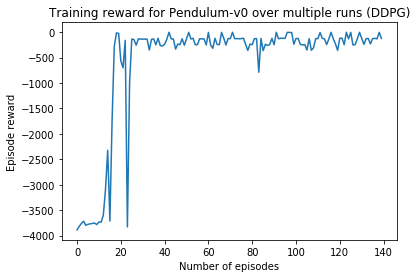

In [11]:
plt.figure()
plt.plot(running_rewards_ddpg)
plt.title('Training reward for Pendulum-v0 over multiple runs (DDPG)')
plt.xlabel('Number of episodes')
plt.ylabel('Episode reward')
plt.savefig('DDPG_Pendulum_episode.png')
plt.show()

## Plot rewards over multiple training runs 
This is provided to generate and plot results for you.

In [12]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2/(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data.transpose()*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

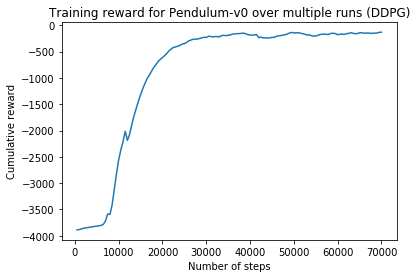

In [13]:
plt.figure()
out = numpy_ewma_vectorized_v2(np.asarray(running_rewards_ddpg),20)
step_list_ddpg = np.asarray(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward for Pendulum-v0 over multiple runs (DDPG)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.savefig('DDPG_Pendulum.png')
plt.show()

In [14]:
np.save('DDPG_Pendulum_rewards.npy', np.asarray(running_rewards_ddpg))
np.save('DDPG_Pendulum_steps.npy', np.asarray(step_list_ddpg))

# REINFORCE

In this section you will implement REINFORCE, with modifications for batch training. It will be for use on both discrete and continous action spaces.

## Policy Parametrization

Define a MLP which outputs a distribution over the action preferences given input state. For the discrete case, the MLP outputs the likelihood of each action (softmax) while for the continuous case, the output is the mean and standard deviation parametrizing the normal distribution from which the action is sampled.



In [2]:
# ----------------------------------------------------
# Policy parametrizing model, MLP
# ----------------------------------------------------
# 1 or 2 hidden layers with a small number of units per layer (similar to DQN)
# use ReLU for hidden layer activations
# softmax as activation for output if discrete actions, linear for continuous control
# for the continuous case, output_dim=2*act_dim (each act_dim gets a mean and std_dev)

class mlp(nn.Module):
    def __init__(self, discrete, input_size, output_size, hidden_size=16):
        super(mlp, self).__init__()
        self.discrete = discrete
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        if self.discrete:
            self.fc3 = nn.Linear(hidden_size, output_size)
        else:
            self.fc3 = nn.Linear(hidden_size, output_size*2)
            
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = Variable(Tensor(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.discrete:
            x = F.softmax(self.fc3(x), dim=0)
        else:
            x = self.fc3(x)
        return x

Define a function that samples an action from the policy distribtion parameters obtained as output of the MLP. The function should return the action and the log-probability (log_odds) of taking that action. 

In [3]:
def sample_action(logit, discrete):
    # logit is the output of the softmax/linear layer
    # discrete is a flag for the environment type
    # Hint: use Categorical and Normal from torch.distributions to sample action and get the log-probability
    # Note that log_probability in this case translates to ln(\pi(a|s)) 
    if discrete:
        m = torch.distributions.Categorical(logit)
    else:
        l = int(logit.data.shape[0] / 2)
        m = torch.distributions.Normal(logit[l:], F.softplus(logit[:l]))
    action = m.sample()
    log_odds = m.log_prob(action)
    return action, log_odds

Create a function update_policy that defines the loss function and updates the MLP according to the REINFORCE update rule (ref. slide 24 of Lec 7 or page 330 of Sutton and Barto (2018)). The update algorithm to be used below is slightly different: instead of updating the network at every time-step, we take the gradient of the loss averaged over a batch of timesteps (this is to make SGD more stable). We also use a baseline to reduce variance. 

The discount factor is set as 1 here. 


In [4]:
def update_policy(paths, net):
    # paths: a list of paths (complete episodes, used to calculate return at each time step)
    # net: MLP object
    
    num_paths = len(paths)
    rew_cums = []
    log_odds = []
    policy_loss = []
    
    for path in paths:
        # rew_cums should record return at each time step for each path 
        rews = path['reward']
        R = 0
        for r in rews[::-1]:
            R = r + R
            rew_cums.append(R)
        
        # log_odds should record log_odds obtained at each timestep of path
        los = path['log_odds']
        for lo in los[::-1]:
            log_odds.append(lo)
         
        # calculated as "reward to go"
    
    # make log_odds, rew_cums each a vector
    rew_cums = torch.Tensor(np.asarray(rew_cums))    
    rew_cums = (rew_cums - rew_cums.mean()) / (rew_cums.std() + 1e-5) # create baseline
        
    # calculate policy loss and average over paths
    for log_prob, reward in zip(log_odds, rew_cums):
        policy_loss.append(-log_prob * reward)
    policy_loss = torch.cat(policy_loss).sum()
    
    # take optimizer step
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

Set up environment and instantiate objects. Your algorithm is to be tested on one discrete and two continuous environments. 



In [7]:
# Select Environment

# discrete environment:
# env_name = 'CartPole-v0'

# continous environments:
env_name = 'InvertedPendulum-v1'
# env_name = 'HalfCheetah-v1'

# Make the gym environment
env = gym.make(env_name)
visualize = False
animate = visualize

learning_rate = 1e-3

max_path_length = 500

# Set random seeds
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Saving parameters
logdir='./REINFORCE/test/'

env._max_episode_steps = max_path_length
if visualize:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%animate_interval==0)

# Is this env continuous, or discrete?
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Get observation and action space dimensions
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]
print('obs_dim: ', obs_dim)
print('act_dim: ', act_dim)
print('max_episode_steps: ', env.spec.max_episode_steps)

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Normalize action
env = NormalizeAction(env)

# Make network object (remember to pass in appropriate flags for the type of action space in use)
net = mlp(discrete, obs_dim, act_dim)

# Make optimizer
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

[2018-05-29 17:01:07,121] Making new env: InvertedPendulum-v1


obs_dim:  4
act_dim:  1
max_episode_steps:  1000


## Run REINFORCE

Run REINFORCE for CartPole, InvertedPendulum, and HalfCheetah. 

In [6]:
n_iter = 1000 
min_timesteps_per_batch = 2000 # sets the batch size for updating network
avg_reward = 0
avg_rewards = []
step_list_reinforce = []
total_steps = 0
episodes = 0

# term_condition = 450 # CartPole
# term_condition = 1500 # HalfCheetah
term_condition = 480 # InvertedPendulum

#done = False
#while not done:
#    _, _, done, _ = env.step(np.zeros(act_dim, dtype=np.int))

for itr in range(n_iter): # loop for number of optimization steps
    paths = []
    steps = 0
    
    while True: # loop to get enough timesteps in this batch --> if episode ends this loop will restart till steps reaches limit
        ob = env.reset()
        obs, acs, rews, log_odds = [], [], [], []
       
        while True: # loop for episode inside batch
            if animate:
                env.render()
                time.sleep(0.05)
            
            # get parametrized policy distribution from net using current state ob
            logit = net(ob)
            
            # sample action and get log-probability (log_odds) from distribution
            net.eval()
            action, log_prob = sample_action(logit, discrete)
            action = np.clip(action.data.numpy(), -1, 1)
            action = action[0] # for CartPole only
            net.train()
            
            # step environment, record reward, next state
            next_ob, reward, done, _ = env.step(action)
            steps += 1
            
            # append to obs, acs, rewards, log_odds
            obs.append(ob)
            acs.append(action)
            rews.append(reward)
            log_odds.append(log_prob)
            
            # if done, restart episode till min_timesteps_per_batch is reached                     
            if done:
                episodes = episodes + 1
                break
                
            ob = next_ob
                
        path = {"observation" : np.array(obs), 
                "reward" : np.array(rews), 
                "action" : np.array(acs),
                "log_odds" : log_odds}
        
        paths.append(path)
        
        if steps > min_timesteps_per_batch:
            break 
        
    update_policy(paths, net) # use all complete episodes (a batch of timesteps) recorded in this itr to update net
    
    if itr == 0:
        avg_reward = path['reward'].sum()
    else:
        avg_reward = 0.95 * avg_reward + 0.05 * path['reward'].sum()
    
    if avg_reward > term_condition:
        break
    
    total_steps += steps
    avg_rewards.append(avg_reward)
    step_list_reinforce.append(total_steps)
    if itr % logging_interval == 0:
        print("Average reward: {} for episode: {}".format(avg_reward, episodes))
        
env.close()

Average reward: 13.0 for episode: 233
Average reward: 17.777977648938776 for episode: 16999
Average reward: 56.55692088908177 for episode: 22894
Average reward: 223.06570159525924 for episode: 24902
Average reward: 456.8423025603919 for episode: 25480


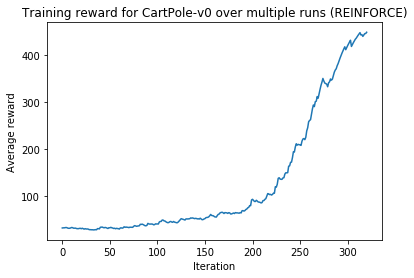

In [21]:
plt.plot(avg_rewards)
plt.title('Training reward for CartPole-v0 over multiple runs (REINFORCE)')
plt.xlabel('Iteration')
plt.ylabel('Average reward')
plt.savefig('REINFORCE_CartPole.png')

In [22]:
np.save('REINFORCE_CartPole-_rewards.npy', np.asarray(avg_rewards))
np.save('REINFORCE_CartPole-_steps.npy', np.asarray(step_list_reinforce))

# BONUS (15% extra)

Compare average returns for CartPole (discrete action space) when using REINFORCE and DQN. Since in REINFORCE we update the network after a set number of steps instead of after every episode, plot the average rewards as a function of steps rather than episodes for both DQN and REINFORCE. You will need to make minor edits to your DQN code from the previous assignment to record average returns as a function of time_steps.

Similarly, compare REINFORCE with DDPG on InvertedPendulum and HalfCheetah using steps for the x-axis.

You may use the example code provided below as a reference for the graphs.


In [23]:
# import your DQN and format your average returns as defined above
running_rewards_DQN = np.load('DQN_CartPole_rewards.npy')
running_rewards_reinforce = np.load('REINFORCE/REINFORCE_CartPole-_rewards.npy')

step_list_DQN = np.load('DQN_CartPole_steps.npy')
step_list_reinforce = np.load('REINFORCE/REINFORCE_CartPole-_steps.npy')

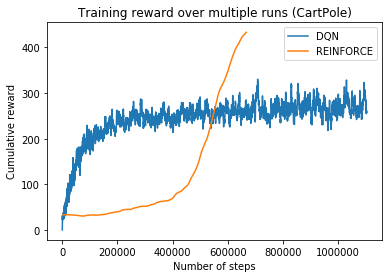

In [24]:
plt.figure()

out_DQN = numpy_ewma_vectorized_v2(running_rewards_DQN,20)
out_reinforce = numpy_ewma_vectorized_v2(running_rewards_reinforce,20)

plt.plot(step_list_DQN, out_DQN) 
plt.plot(step_list_reinforce, out_reinforce)
plt.title('Training reward over multiple runs (CartPole)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DQN', 'REINFORCE'])
plt.savefig('CartPole_ddpg_reinforce.png')
plt.show()

In [25]:
running_rewards_ddpg = np.load('DDPG/DDPG_HalfCheetah_rewards.npy')
running_rewards_reinforce = np.load('REINFORCE/REINFORCE_HalfCheetah_rewards.npy')

step_list_ddpg = np.load('DDPG/DDPG_HalfCheetah_steps.npy')
step_list_reinforce = np.load('REINFORCE/REINFORCE_HalfCheetah_steps.npy')

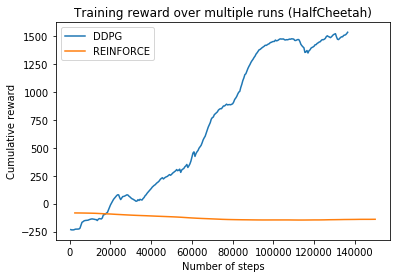

In [26]:
plt.figure()

out_ddpg = numpy_ewma_vectorized_v2(running_rewards_ddpg,20)
out_reinforce = numpy_ewma_vectorized_v2(running_rewards_reinforce,20)

plt.plot(step_list_ddpg, out_ddpg) 
plt.plot(step_list_reinforce[0:60], out_reinforce[0:60])
plt.title('Training reward over multiple runs (HalfCheetah)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE'])
plt.savefig('HalfCheetah_ddpg_reinforce.png')
plt.show()

In [27]:
running_rewards_ddpg = np.load('DDPG/DDPG_InvertedPendulum_rewards.npy')
running_rewards_reinforce = np.load('REINFORCE/REINFORCE_InvertedPendulum_rewards.npy')

step_list_ddpg = np.load('DDPG/DDPG_InvertedPendulum_steps.npy')
step_list_reinforce = np.load('REINFORCE/REINFORCE_InvertedPendulum_steps.npy')

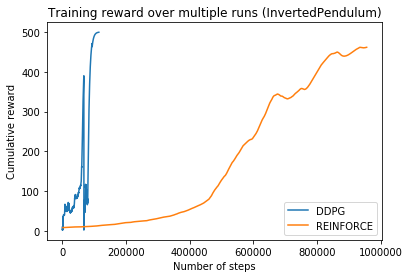

In [28]:
plt.figure()

out_ddpg = numpy_ewma_vectorized_v2(running_rewards_ddpg,20)
out_reinforce = numpy_ewma_vectorized_v2(running_rewards_reinforce,20)

plt.plot(step_list_ddpg, out_ddpg) 
plt.plot(step_list_reinforce[0:450], out_reinforce[0:450])
plt.title('Training reward over multiple runs (InvertedPendulum)')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.legend(['DDPG', 'REINFORCE'])
plt.savefig('InvertedPendulum_ddpg_reinforce.png')
plt.show()